# Waterfall plot

In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.classifier import (
    sample,
    linear_classifier_score,
    antilogit_classifier_score,
    z_score,
    sample_single_patient,
)

In [4]:
### Reading csv file containing 243 subjects and their raw TPM counts across 1059 genes
### Source of data
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
# setting index row name to the gene id
raw_data = raw_data.set_index("gene_id")

In [5]:
# Loading sheet 0, which contains the clinical diagnoses
pathos = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=0
)
pathos = pathos[~pathos.loc[:, "Isolate ID"].isna()]
pathos = pathos.astype({"Isolate ID": "int"})
pathos = pathos.set_index("Isolate ID")

In [6]:
# Filtering out rows: discarding the ERCC rows, ERCC is a control protocol for validation of RNA sequencing
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]

# We store the coefficients(betas) of the linear classifier in an array.
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))

# Filtering out columns with patient data
patients_df = patients_df.filter(regex=r"^\d+")

In [7]:
# group columns by patient id
grouped_cols = patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

/tmp/ipykernel_320704/3094510434.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [8]:
# Computing and storing zscores
means, stds = patients_df.mean(axis=1), patients_df.iloc[:, :-1].std(axis=1)
z_scores_df = patients_df.iloc[:, :-3].apply(lambda x: z_score(x, means, stds))
z_scores_df = z_scores_df.filter(regex=r"^\d+")

In [9]:
probs = antilogit_classifier_score(z_scores_df.T @ coefficients)
probs = probs.sort_values()

In [10]:
probs.index = [int(x) for x in probs.index]

In [11]:
probs_df = pd.DataFrame({"probs": probs})

In [12]:
threshold = 0.5

In [13]:
probs_df["probs"] -= threshold
for val in probs.index:
    if pathos.loc[val, "Disease"] == "AD":
        probs_df.loc[val, "disease"] = "AD"
    else:
        probs_df.loc[val, "disease"] = "NCI"
        "#87cefa"

In [14]:
probs_df["x"] = np.linspace(0, 40, probs.shape[0])

In [15]:
ad_filt = probs_df["disease"] == "AD"

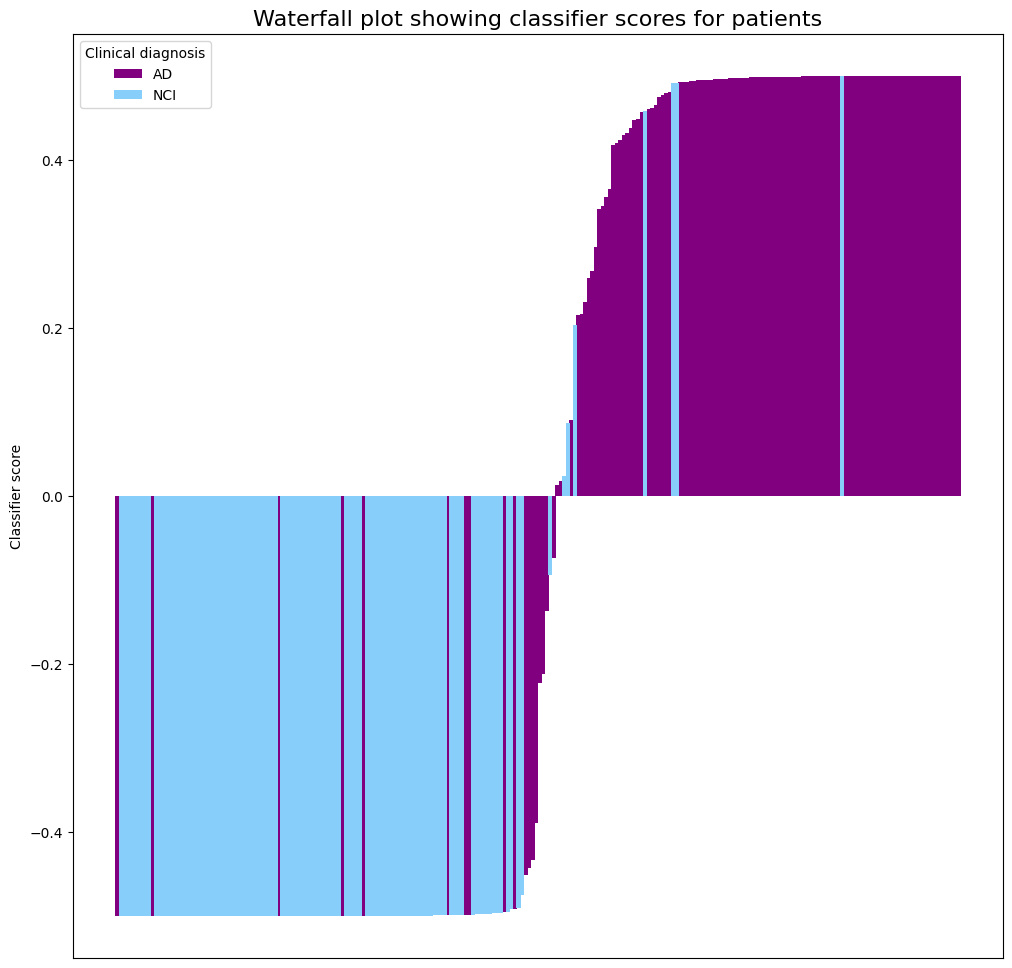

In [16]:
plt.figure(figsize=(12, 12))
plt.bar(probs_df.loc[ad_filt, "x"], probs_df.loc[ad_filt, "probs"], width=0.2, color="#800080", label="AD")
plt.bar(probs_df.loc[~ad_filt, "x"], probs_df.loc[~ad_filt, "probs"], width=0.2, color="#87cefa", label="NCI")
plt.xticks([])
plt.ylabel("Classifier score")
plt.legend(title="Clinical diagnosis")
plt.title("Waterfall plot showing classifier scores for patients", fontsize=16)
plt.show()